In [1]:
%load_ext autoreload
%autoreload 2
%reset -f
from custom_imports import *

In [2]:
client = Client(scheduler_file="/home/bzr0014/schedfile")

In [3]:
client.restart()

Client Scheduler: tcp://131.204.27.88:8786 Dashboard: http://131.204.27.88:8787/status,Cluster Workers: 50 Cores: 100 Memory: 1000.00 GB


In [4]:
DATAROOT = "data"

In [5]:
multi_class_images = joblib.load(f"{DATAROOT}/multi_label_images.dict")
image_names = joblib.load(f"{DATAROOT}/image_names.pkl")

In [6]:
raw_images = {k: v for k, v in dict(zip(image_names, joblib.load(f"{DATAROOT}/raw_images.pkl"))).items() if k in multi_class_images}

In [7]:
original_images = {k: v for k, v in dict(zip(image_names, joblib.load(f"{DATAROOT}/images.pkl"))).items() if k in multi_class_images}

In [8]:
assert len(raw_images) == len(original_images)
assert len(raw_images) == len(multi_class_images)

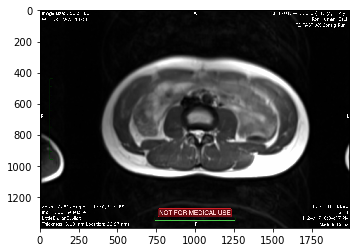

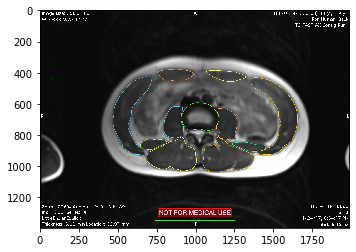

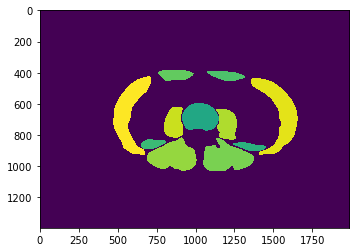

In [196]:
label = np.random.choice(list(multi_class_images.keys()))
plt.imshow(raw_images[label])
plt.show()
plt.imshow(original_images[label])
plt.show()
plt.imshow(multi_class_images[label])

In [198]:
def get_contours(x):
    _, cnts, _ = cv2.findContours(x.astype('uint8'),cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    return cnts

In [209]:
def get_bulk(k, x):
    if len(x.shape)>2:
        x = x.mean(axis=2)
    x = x.astype('uint8')
    y = cv2.equalizeHist(x)
    t = cv2.medianBlur(y, 3)
    z = cv2.erode((1-(t < t.mean()-t.std()/20)).astype('uint8'), np.ones((31, 31)), 5)
    cnts = [cv2.convexHull(i) for i in sorted(get_contours(z), key=lambda x: -len(x))[:1]]
    #cnts = [i for i in sorted(get_contours(z), key=lambda x: -len(x))[:1]]
    out = np.zeros_like(z)
    cv2.drawContours(out, cnts, 0, 1, -1)
    #y = cv2.erode(cv2.Laplacian(cv2.medianBlur(x, 301), cv2.CV_8U, ksize=27), np.ones((3, 3)))
    return out

In [210]:
bulks_d = {k: delayed(get_bulk)(k, v) for k, v in raw_images.items()}

In [211]:
bulks = compute(bulks_d)[0]

In [226]:
x = list(bulks.values())[5]
dist = compute([delayed(lambda x: np.sqrt(np.sum((np.array(np.where(x)).mean(axis=1) - np.array(x.shape)/2)**2)))(x) 
                for x in list(bulks.values())])[0]

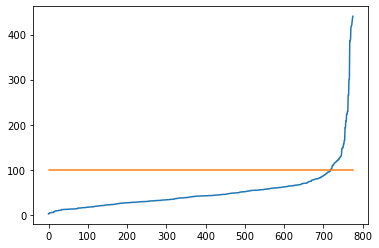

In [280]:
x = np.arange(len(dist))
q1, q3 = np.percentile(dist, [25, 95])
iqr = q3 - q1
plt.plot(x, sorted(dist))
plt.plot([x[0], x[-1]], [100]*2)

In [260]:
from sklearn.cluster import KMeans
m = KMeans(n_clusters=2)
m.fit(np.array(dist).reshape(-1, 1))

KMeans(n_clusters=2)

In [685]:
from functools import reduce
bad_stuff = reduce(lambda x, y: set(x) | set(y), map(joblib.load, glob.glob("data/bad*")))
len(bad_stuff)

430

In [529]:
def get_area_ratio(x):
    cnts = get_contours(x)[0]
    _, r = cv2.minEnclosingCircle(cnts)
    return (r*r/cv2.contourArea(cnts))
res = compute([delayed(get_area_ratio)(x) for x in bulks.values()])[0]

In [684]:
joblib.dump({k for k, v in zip(bulks, res) if v > .5}, "data/bad_enclosing_circle.set")

['data/bad_enclosing_circle.set']

(array([325,  89]), array([1116, 1275]))

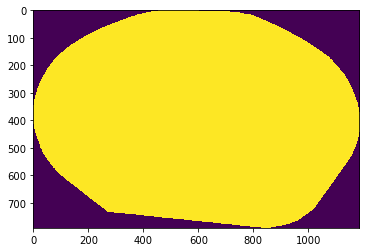

In [465]:
plt.imshow(bulks[label][325:1116, 89:1275])
np.array(np.where(bulks[label])).min(axis=1), np.array(np.where(bulks[label])).max(axis=1)

mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Pre/Female/Subject WF1/2-FCWF1-10:50Beh-Rep.jpg
206 1236 141 1796
(1394, 1982) (1394, 1982, 3) (1394, 1982)


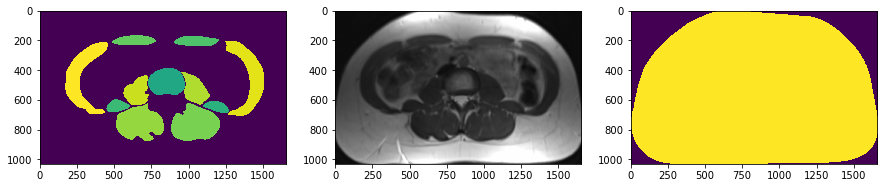

0.47948269170722396

In [694]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
label = np.random.choice(list(multi_class_images.keys()-bad_stuff))
#label = "mri_analysis/3.Contiguous Set#1/Control/Control - Post/Male/Subject M3B/2-COM3B-9:50Behnam.jpg"
#label = "mri_analysis/1.Multigroup Set#1_DONE/Control/Control - Pre/Controls-Male/Subject M6/2.CO6-7:16.jpg"
#label = "mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Pre/Female/Subject WF1/1.FCWF1-2:16.jpg"
print(label)
y = multi_class_images[label]
x = cv2.resize(bulks[label], y.shape[::-1])
z = cv2.resize(raw_images[label], y.shape[::-1])
t = np.where(x)
xmn, ymn = np.min(t, axis=1)
xmx, ymx = np.max(t, axis=1)
print(xmn, xmx, ymn, ymx)
axes[0].imshow(y[xmn:xmx, ymn:ymx])
axes[1].imshow(z[xmn:xmx, ymn:ymx])
axes[2].imshow(x[xmn:xmx, ymn:ymx])
print(x.shape, z.shape, y.shape)
plt.show()
get_area_ratio(bulks[label])

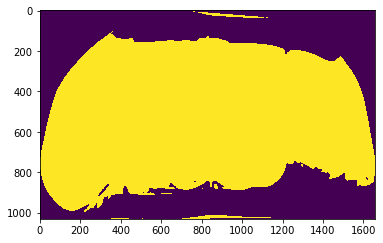

In [695]:
f =  cv2.equalizeHist(z[xmn:xmx, ymn:ymx].mean(axis=2).astype('uint8'))
t =  x[xmn:xmx, ymn:ymx]#.mean(axis=2)
plt.imshow((1-(f>f.mean()+f.std()))*t)

In [698]:
from sklearn.model_selection import train_test_split
imgTrLabels, imgTsLabels, maskedTrLabels, maskedTsLabels = \
    train_test_split(list(original_images.keys()-bad_stuff), list(multi_class_images.keys()-bad_stuff), random_state=17, test_size=.6)
imgTr = {k: original_images[k] for k in imgTrLabels}
imgTs = {k: original_images[k] for k in imgTsLabels}
maskedTr = {k: multi_class_images[k] for k in maskedTrLabels}
maskedTs = {k: multi_class_images[k] for k in maskedTsLabels}
assert len(imgTr) == len(maskedTr)
assert len(imgTs) == len(maskedTs)

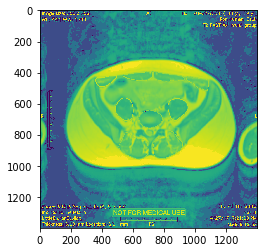

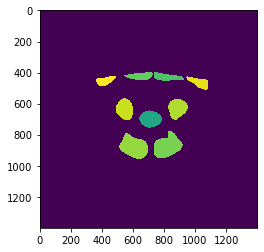

In [699]:
label = np.random.choice(list(maskedTr.keys()))
plt.imshow(cv2.equalizeHist(imgTr[label].mean(axis=2).astype('uint8')))
plt.show()
plt.imshow(maskedTr[label])

In [700]:
def clean_image(img, shape):
    if len(img.shape) > 2:
        img = img.mean(axis=2).astype('uint8')
    cleaned_hist_img = cv2.equalizeHist(img)
    gaussian_kernel_size = tuple(((x//40)//2)*2+1 for x in cleaned_hist_img.shape)
    blurred_img = cv2.GaussianBlur(cleaned_hist_img, gaussian_kernel_size, 1)
    zoom_rate = tuple(x/y for x,y in zip(shape, img.shape)) if isinstance(shape, tuple) \
                else shape if shape < 1 else shape/img.shape[0]
    out = zoom(blurred_img, zoom_rate)
    return (out-out.mean())/out.std()

def clean_mask(img, shape):
    if len(img.shape) > 2:
        img = img.sum(axis=2).astype('uint8')
    zoom_rate = tuple(x/y for x,y in zip(shape, img.shape)) if isinstance(shape, tuple) \
                else shape if shape < 1 else shape/img.shape[0]
    out = []
    for c in sorted(np.unique(img))[1:]:
        segment = (zoom((img==c)*255, zoom_rate)>0)*c
        out.append(segment)
    return np.max(np.array(out), axis=0)

#def get_image_positional_values(img):
#    w, h, *_ = img.shape
#    x, y = np.meshgrid(np.arange(w)/w, np.arange(h)/h)
#    return np.vstack([x.reshape(-1), y.reshape(-1)]).T, img.reshape(-1)



mri_analysis/4.Contiguous Set#2/Control/Control - Pre/Female/Subject F6/2-COF6-10:50Rep-Beh.jpg


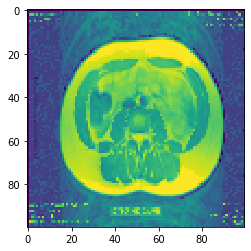

[  0 150 160 170 180 190 200 210 220 230 240 250]


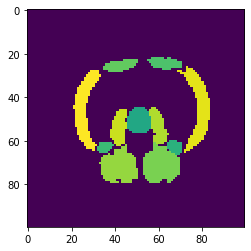

In [701]:
label = np.random.choice(list(maskedTr.keys()))
#label = "mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Post/Female/Subject WF5B/1-WF5B-4:50RepBeh.jpg"
#label = 'mri_analysis/4.Contiguous Set#2/Control/Control - Pre/Female/Subject F4/3-COF4-15:50Rep-Beh.jpg'
print(label)
plt.imshow(clean_image(imgTr[label], (100, 100)))
plt.show()
tmp = clean_mask(maskedTr[label], (100, 100))
plt.imshow(tmp)
print(np.unique(tmp))

In [702]:
imgTrB = bag.from_sequence(imgTr.values())
maskedTrB = bag.from_sequence(maskedTr.values())

In [703]:
cleaned_images_bag = imgTrB.map(clean_image, shape=300).persist()#[delayed(clean_image)(x, 200) for x in imgTr.values()]
cleaned_masks_bag = maskedTrB.map(clean_mask, shape=300).persist()#[delayed(clean_image)(x, 200) for x in imgTr.values()]

In [704]:
def sample(x, y, neighSize, step):
    m1 = neighSize//2
    m2 = neighSize-m1
    w, h, *_ = x.shape
    x_out = []
    y_out = []
    for i in range(m1, w-m2, step):
        for j in range(m1, h-m2, step):
            x_out.append(x[i-m1:i+m2, j-m1:j+m2])
            y_out.append(y[i, j])
    x = np.array(x_out)
    y = np.array(y_out)
    return x.reshape(*x.shape, 1), y.reshape(*y.shape, 1)

In [705]:
XY_bag = bag.map(sample, cleaned_images_bag, cleaned_masks_bag, 41, 3)

In [706]:
XY = XY_bag.compute()

In [29]:
X = np.concatenate([x[0] for x in XY])
Y = np.concatenate([x[1] for x in XY])
encoder = OneHotEncoder()
#Y = encoder.fit_transform(Y).toarray()

In [2]:
import tensorflow as tf

NameError: name 'XY' is not defined

In [53]:
Y[Y>0] = (Y[Y>0]/10)-14

In [58]:
Y = Y.reshape(-1)

In [59]:
import tensorflow as tf
layer_1_filter_size = 3
layer_1_filter_num = 20
layer_1_stride = 1
layer_2_filter_size = 5
layer_2_filter_num = 20
layer_2_stride = 1
layer_3_filter_num = 20
layer_3_filter_size = 7
layer_3_stride = 1
layer_3_dropout_rate = .25

n_fc1 = 128
fc1_dropout_rate = .5
neighSize = 41

n_outputs = 12
output_shape = layer_3_filter_num * \
    (neighSize-layer_1_filter_size-layer_2_filter_size-layer_3_filter_size+3)**2

tf.reset_default_graph()

print("output shape:", output_shape)

with tf.name_scope('inputs'):
    X_tf = tf.placeholder(tf.float32, [None, neighSize, neighSize, 1])
    y_tf = tf.placeholder(tf.int64, [None])
    punishment1 = tf.ones_like(y_tf)
    punishment2 = tf.ones_like(y_tf) * 10
    punishment = tf.cast(tf.where(y_tf == 0, punishment1, punishment2), tf.float32)
    training = tf.placeholder_with_default(False, shape=[], name='training')    
    
with tf.name_scope('convs'):
    conv1 = tf.layers.conv2d(X_tf, filters=layer_1_filter_num, kernel_size=layer_1_filter_size,\
                             strides=layer_1_stride, padding='SAME',\
                             activation=tf.nn.relu, name='conv1')
    conv2 = tf.layers.conv2d(X_tf, filters=layer_2_filter_num, kernel_size=layer_2_filter_size,\
                             strides=layer_2_stride, padding='SAME',\
                             activation=tf.nn.relu, name='conv2')
    conv3 = tf.layers.conv2d(X_tf, filters=layer_3_filter_num, kernel_size=layer_3_filter_size,\
                             strides=layer_3_stride, padding='SAME',\
                             activation=tf.nn.relu, name='conv3')   
with tf.name_scope('skip'):
    #skip = conv3 + X_tf
    skip = tf.concat([conv3, X_tf], axis=3)
    print(skip)
    skip_drop = tf.layers.dropout(skip, rate=layer_3_dropout_rate, training=training)
    skip_flat = tf.reshape(skip_drop, shape=[-1, neighSize*neighSize*(layer_3_filter_num+1)])

with tf.name_scope('fc1'):
    fc1 = tf.layers.dense(skip_flat, n_fc1, activation=tf.nn.relu, name='fc1')
    fc1_drop = tf.layers.dropout(fc1, rate=fc1_dropout_rate, training=training)

with tf.name_scope('output'):
    logits = tf.layers.dense(fc1_drop, n_outputs, name='output')
    y_prob = tf.nn.softmax(logits, name='y_prob')

with tf.name_scope('training'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y_tf)
    loss = tf.reduce_mean(xentropy)# * punishment)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y_tf, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
with tf.name_scope('init_and_save'):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

output shape: 16820
Tensor("skip/concat:0", shape=(?, 41, 41, 21), dtype=float32)


In [70]:
def load_model(checkpoint_path):
    if os.path.isfile(checkpoint_path+'.data-00000-of-00001'):
        print("File already exists")
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)

In [72]:
import numpy as np
n_epochs = 1000
batch_size = 10000
train_indicies = np.arange(X.shape[0])
model_name = './best'

best_loss_val = np.infty
check_interval = 500
checks_since_last_progress = 0
max_checks_without_progress = 30
best_model_params = None 

with tf.Session() as sess:
    try:
        load_model(model_name)
        for epoch in range(n_epochs):
            np.random.shuffle(train_indicies)
            acc_trains = []
            for iteration in range(int(np.ceil(X.shape[0]/batch_size))):

                start_idx = (iteration*batch_size)%X.shape[0]
                idx = train_indicies[start_idx:start_idx+batch_size]
                X_batch = X[idx, :]
                y_batch = Y[idx]
                _, batch_acc = sess.run([training_op, accuracy], feed_dict={X_tf: X_batch, y_tf: y_batch, training: True})
                acc_trains.append(batch_acc)
                if iteration % 10000:
                    print(iteration,int(np.ceil(X.shape[0]/batch_size)), batch_acc)


            #acc_train = accuracy.eval(feed_dict={X_tf: X[train_indicies[:1000]], y_tf: y_train[train_indicies[:1000]]})
            #print("%03d Train accuracy: %6.4f | loss: %5.3f"%(acc_train))
            if checks_since_last_progress > max_checks_without_progress:
                print("Early stopping!")
                break
            save_path = saver.save(sess, model_name)

        if best_model_params:
            restore_model_params(best_model_params)
        acc_test = accuracy.eval(feed_dict={X_tf: X, y_tf: Y})
        print("Final accuracy on test set:", acc_test)
    except KeyboardInterrupt:
        save_path = saver.save(sess, model_name)

File already exists
INFO:tensorflow:Restoring parameters from ./best
1 293 0.838
2 293 0.838
3 293 0.8345
4 293 0.8378
5 293 0.8393


In [63]:
import time
try:
    time.sleep(10)
except KeyboardInterrupt:
    pass

In [107]:
x = list(multi_class_images.values())
y = list(raw_images.values())

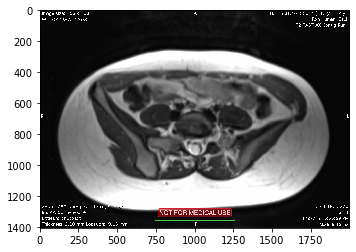

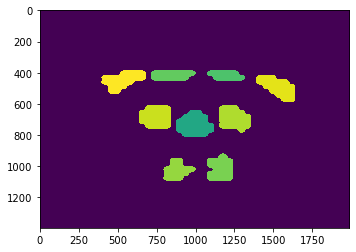

In [123]:
n = np.random.randint(len(x))
n = 0
plt.imshow(y[n])
plt.show()
out = np.zeros_like(x[n])
for i in sorted(np.unique(x[n])):
    out += cv2.dilate(cv2.resize(cv2.resize((x[n]==i).astype('uint8'), (50, 50)), x[n].shape[::-1]), 
                      np.ones((10, 10)))*i
plt.imshow(out)

In [117]:
#lens = client.map[len(np.unique(i)) for i in x]
x_b = bag.from_sequence(x)

In [120]:
res = x_b.map(np.unique).compute()

In [127]:
out = dict(zip(multi_class_images.keys(), res))

In [131]:
bad_items = [k for k, x in out.items() if len(x)-1 not in {9, 11}]

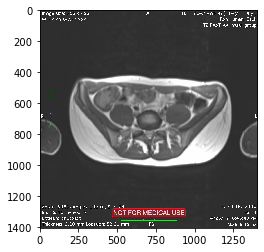

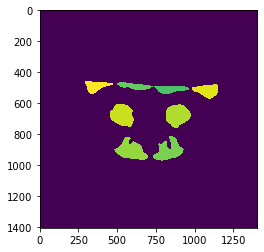

In [145]:
n = np.random.choice((bad_items))
plt.imshow(raw_images[n])
plt.show()
plt.imshow(multi_class_images[n])

In [146]:
joblib.dump(bad_items, "data/bad_images.list")

['data/bad_images.list']